In [1]:
%%system
rm /scratch/ors -r
mkdir /scratch/ors-buildings
mkdir /scratch/ors-buildings/dmg
cp ~/ors-project/buildings-data.zip /scratch/ors-buildings
unzip buildings-data.zip -d /scratch/ors-buildings

["rm: cannot remove '/scratch/ors': No such file or directory",
 'mkdir: cannot create directory ‘/scratch/ors-buildings’: File exists',
 'mkdir: cannot create directory ‘/scratch/ors-buildings/dmg’: File exists',
 'Archive:  buildings-data.zip',
 'replace /scratch/ors-buildings/clr/22678915_15.png? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [2]:
from fastai.vision.all import *
from PIL import Image, ImageDraw
from random import randint

In [3]:
import wandb
wandb.init(project="ors_project", entity="android100")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: android100 (use `wandb login --relogin` to force relogin)


In [4]:
from fastai.callback.wandb import *

In [5]:
path = Path("/scratch/ors-buildings/")
path_clear = path/"clr"
path_damaged = path/"dmg"

In [6]:
LINE_WIDTH = 2
STRIP_IMAGE_SIZE = 512

In [7]:
stripes_base = Image.new("RGBA", (STRIP_IMAGE_SIZE, STRIP_IMAGE_SIZE), (255, 255, 255, 0))
stripes = ImageDraw.Draw(stripes_base)
for y in range(int(1.1 * LINE_WIDTH), int(STRIP_IMAGE_SIZE - 0.1 * LINE_WIDTH), 20):
    stripes.line([0, y, STRIP_IMAGE_SIZE, y], width=LINE_WIDTH, fill="BLACK")

def damage_image(image_path):    
    img = Image.open(image_path)
    img = img.resize((256, 256))
    damage_lines = stripes_base.rotate(random.randint(0, 360))
    damage_lines = damage_lines.crop(((STRIP_IMAGE_SIZE - 256)/2, (STRIP_IMAGE_SIZE - 256)/2, (STRIP_IMAGE_SIZE + 256)/2, (STRIP_IMAGE_SIZE + 256)/2, ))
    img.paste(damage_lines, (0, 0), damage_lines)
    img.save(path_damaged/image_path.name)

In [8]:
parallel(damage_image, path_clear.ls(), n_workers=8, progress=True)

(#151) [None,None,None,None,None,None,None,None,None,None...]

In [9]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                  get_items=get_image_files,
                  get_y=lambda x: path_clear/x.name,
                  splitter=RandomSplitter(),
                  item_tfms=Resize(224),
                  batch_tfms=[*aug_transforms(max_zoom=2.),
                             Normalize.from_stats(*imagenet_stats)])

In [10]:
dls = dblock.dataloaders(path_damaged, bs=8)

/home2/s.ranjan/miniconda3/envs/ors/lib/python3.6/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [11]:
dls_gen = dls
dls_gen.c = 3

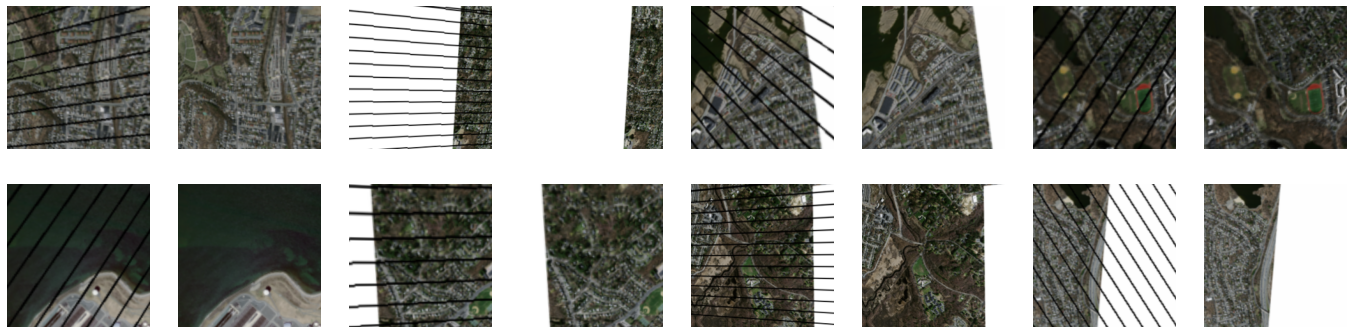

In [12]:
dls_gen.show_batch()

In [13]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [14]:
bbone = resnet34
# cfg = unet_config(blur=True, norm_type=NormType.Weight, self_attention=True,
#                   y_range=y_range)

In [15]:
def create_gen_learner():
    return unet_learner(dls_gen, bbone, loss_func=loss_gen, cbs=WandbCallback())

In [16]:
learn_gen = create_gen_learner()

In [17]:
learn_gen.fit_one_cycle(20, pct_start=0.8, wd=wd)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,time
0,0.652551,0.592129,00:11
1,0.426008,0.246538,00:10
2,0.322510,0.184257,00:09
3,0.262205,0.165315,00:09
4,0.219942,0.188716,00:09
5,0.185220,0.134949,00:10
6,0.154804,0.113354,00:09
7,0.128928,0.089609,00:11
8,0.108959,0.084514,00:09
9,0.093333,0.087881,00:10


In [18]:
learn_gen.unfreeze()

In [21]:
learn_gen.fit_one_cycle(5, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.025933,0.047932,00:10
1,0.027183,0.041716,00:10
2,0.027229,0.039404,00:09
3,0.028248,0.039901,00:10
4,0.026443,0.038669,00:10


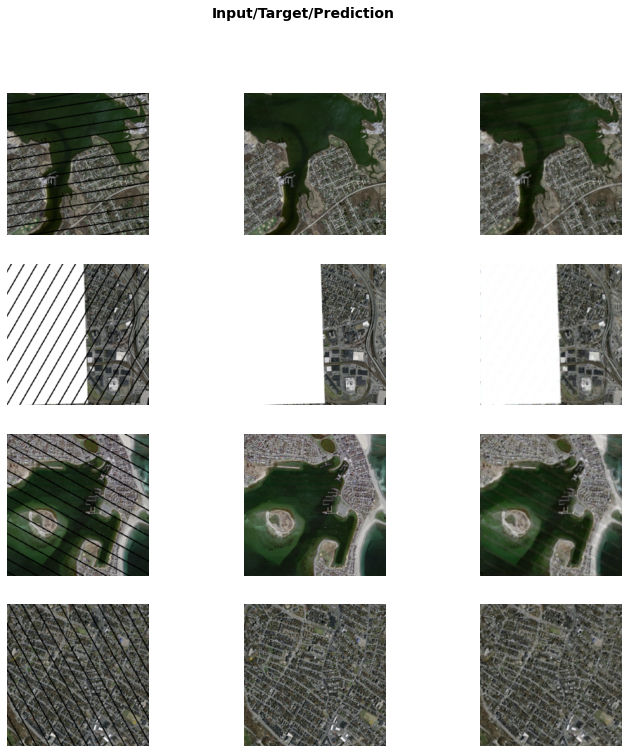

In [22]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [23]:
learn_gen.save('image_restoration_buildings')

Path('models/image_restoration_buildings.pth')

In [24]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▂▂▂▃▃▃▄▄▅▅▆▆▇▇▇████▇▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▁▂▂▂▃▃▃▄▄▅▅▆▆▇▇▇████▇▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_2,▁▁▁▂▂▂▃▃▃▄▄▅▅▆▆▇▇▇████▇▆▄▂▁▃█▇▅▃▁▁▆█▆▄▂▁
mom_0,████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▂▃▅▇█▆▁▂▄▆██▃▁▃▅▇█
mom_1,████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▂▃▅▇█▆▁▂▄▆██▃▁▃▅▇█
mom_2,████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▂▃▅▇█▆▁▂▄▆██▃▁▃▅▇█
raw_loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
